# Plotting auroc 

In [53]:
#%reset
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix
from num2words import num2words
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score
import word2number
from word2number import w2n
from sklearn.tree import DecisionTreeClassifier
import pickle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay

#from Functions import prep_training_test_data_period, prep_training_test_data
hfont = {'fontname':'Helvetica'}

In [26]:
def prep_training_test_data_period(
    data, no_weeks, weeks_in_future, geography, weight_col, keep_output
):
    ## Get the weeks for the x and y datasets
    x_weeks = []
    y_weeks = []
    y_weeks_to_check = []  # check these weeks to see if any of them are equal to 1
    for week in no_weeks:
        test_week = int(week) + weeks_in_future
        x_weeks.append("_" + num2words(week) + "_")
        for week_y in range(week + 1, test_week + 1):
            y_weeks_to_check.append("_" + num2words(week_y) + "_")
        y_weeks.append("_" + num2words(test_week) + "_")

    ## Divide up the test/train split
    # if is_geographic:
    # Calculate the index to start slicing from
    #    start_index = len(data['county']) // proportion[0] * proportion[1]
    # Divide up the dataset based on this proportion
    #    first_two_thirds = data['county'][:start_index]
    #    last_third = data['county'][start_index:]
    X_data = pd.DataFrame()
    y_data = pd.DataFrame()
    weights_all = pd.DataFrame()
    missing_data = []
    ## Now get the training data
    k = 0
    for x_week in x_weeks:
        y_week = y_weeks[k]
        k += 1

        weeks_x = [col for col in data.columns if x_week in col]
        columns_x = [geography] + weeks_x + [weight_col]
        data_x = data[columns_x]

        weeks_y = [col for col in data.columns if y_week in col]
        columns_y = [geography] + weeks_y
        data_y = data[columns_y]
        ### now add the final column to the y data that has it so that it's if any week in the trhee week perdiod exceeded 15
        train_week = w2n.word_to_num(x_week.replace("_", ""))
        target_week = w2n.word_to_num(y_week.replace("_", ""))
        y_weeks_to_check = []
        for week_to_check in range(train_week + 1, target_week + 1):
            y_weeks_to_check.append("_" + num2words(week_to_check) + "_")

        y_weeks_to_check = [week + "beds_over_15_100k" for week in y_weeks_to_check]
        columns_to_check = [
            col for col in data.columns if any(week in col for week in y_weeks_to_check)
        ]
        y_over_in_period = data[columns_to_check].apply(max, axis=1)
        data_y = pd.concat([data_y, y_over_in_period], axis=1)
        # ensure they have the same amount of data
        # remove rows in test_data1 with NA in test_data2
        data_x = data_x.dropna()
        data_x = data_x[data_x[geography].isin(data_y[geography])]
        # remove rows in test_data2 with NA in test_data1
        data_y = data_y.dropna()
        data_y = data_y[data_y[geography].isin(data_x[geography])]
        data_x = data_x[data_x[geography].isin(data_y[geography])]
        data_x_no_HSA = len(data_x[geography].unique())

        missing_data.append(
            (
                (len(data[geography].unique()) - data_x_no_HSA)
                / len(data[geography].unique())
            )
            * 100
        )
        # get weights
        # weights = weight_data[weight_data[geography].isin(data_x[geography])][[geography, weight_col]]

        X_week = data_x.iloc[:, 1 : len(columns_x)]  # take away y, leave weights for mo
        y_week = data_y.iloc[:, -1]

        y_week = y_week.astype(int)
        weights = X_week.iloc[:, -1]
        if keep_output:
            X_week = X_week.iloc[
                :, : len(X_week.columns) - 1
            ]  # remove the weights and leave "target" for that week

            # rename columns for concatenation
            X_week.columns = range(1, len(data_x.columns) - 1)
        else:
            X_week = X_week.iloc[
                :, : len(X_week.columns) - 2
            ]  # remove the weights and  "target" for that week

            X_week.columns = range(
                1, len(data_x.columns) - 2
            )  # remove the weights and  "target" for that week

        y_week.columns = range(1, len(data_y.columns) - 2)
        X_data = pd.concat([X_data, X_week])
        y_data = pd.concat([y_data, y_week])

        weights_all = pd.concat([weights_all, weights])

    X_data.reset_index(drop=True, inplace=True)
    y_data.reset_index(drop=True, inplace=True)
    weights_all.reset_index(drop=True, inplace=True)

    return (X_data, y_data, weights_all, missing_data)


### this code it's ANY in the x week period
def prep_training_test_data(
    data, no_weeks, weeks_in_future, geography, weight_col, keep_output
):
    ## Get the weeks for the x and y datasets
    x_weeks = []
    y_weeks = []
    for week in no_weeks:
        test_week = int(week) + weeks_in_future
        x_weeks.append("_" + num2words(week) + "_")
        y_weeks.append("_" + num2words(test_week) + "_")

    X_data = pd.DataFrame()
    y_data = pd.DataFrame()
    weights_all = pd.DataFrame()
    missing_data = []
    ## Now get the training data
    k = 0
    for x_week in x_weeks:
        y_week = y_weeks[k]
        k += 1
        weeks_x = [col for col in data.columns if x_week in col]
        columns_x = [geography] + weeks_x + [weight_col]
        data_x = data[columns_x]

        weeks_y = [col for col in data.columns if y_week in col]
        columns_y = [geography] + weeks_y
        data_y = data[columns_y]
        # ensure they have the same amount of data
        # remove rows in test_data1 with NA in test_data2
        data_x = data_x.dropna()
        data_x = data_x[data_x[geography].isin(data_y[geography])]
        # remove rows in test_data2 with NA in test_data1
        data_y = data_y.dropna()
        data_y = data_y[data_y[geography].isin(data_x[geography])]
        data_x = data_x[data_x[geography].isin(data_y[geography])]
        data_x_no_HSA = len(data_x[geography].unique())

        missing_data.append(
            (
                (len(data[geography].unique()) - data_x_no_HSA)
                / len(data[geography].unique())
            )
            * 100
        )
        # get weights
        # weights = weight_data[weight_data[geography].isin(data_x[geography])][[geography, weight_col]]

        X_week = data_x.iloc[:, 1 : len(columns_x)]  # take away y, leave weights for mo
        y_week = data_y.iloc[:, -1]

        y_week = y_week.astype(int)
        weights = X_week.iloc[:, -1]
        if keep_output:
            X_week = X_week.iloc[
                :, : len(X_week.columns) - 1
            ]  # remove the weights and leave "target" for that week

            # rename columns for concatenation
            X_week.columns = range(1, len(data_x.columns) - 1)
        else:
            X_week = X_week.iloc[
                :, : len(X_week.columns) - 2
            ]  # remove the weights and  "target" for that week

            X_week.columns = range(
                1, len(data_x.columns) - 2
            )  # remove the weights and  "target" for that week

            # rename columns for concatenation
        y_week.columns = range(1, len(data_y.columns) - 1)
        X_data = pd.concat([X_data, X_week])
        y_data = pd.concat([y_data, y_week])

        weights_all = pd.concat([weights_all, weights])

    X_data.reset_index(drop=True, inplace=True)
    y_data.reset_index(drop=True, inplace=True)
    weights_all.reset_index(drop=True, inplace=True)

    return (X_data, y_data, weights_all, missing_data)

# Get data

In [2]:
HSA_weekly_data_all = pd.read_csv("/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates_weekly.csv")

In [28]:
columns_to_select = HSA_weekly_data_all.filter(regex="HSA|beds_over_15_100k|weight").columns.tolist()
naive_data = HSA_weekly_data_all[columns_to_select]

columns_to_select = HSA_weekly_data_all.filter(regex="HSA|cases|perc_covid|admits|beds_over_15_100k|weight").columns.tolist()
columns_to_select = [col for col in columns_to_select if "delta" not in col]

CDC_data = HSA_weekly_data_all[columns_to_select]



Naive datasets

In [66]:
X_train_naive_period, y_train_naive_period, weights_naive_period, missing_data_train_HSA = prep_training_test_data_period(naive_data,  no_weeks = range(1, int(123*2/3) + 1), weeks_in_future =  3, geography = 'HSA_ID', weight_col = 'weight', keep_output = True)

X_test_naive_period, y_test_naive_period, weights_test_naive_period, missing_data_test_HSA = prep_training_test_data_period(naive_data,  no_weeks = range(int(123*2/3) + 1, 120), weeks_in_future =  3, geography = 'HSA_ID',  weight_col = 'weight', keep_output = True)

X_train_naive_exact, y_train_naive_exact, weights_naive_exact, missing_data_train_HSA = prep_training_test_data(naive_data,  no_weeks = range(1, int(123*2/3) + 1), weeks_in_future =  3, geography = 'HSA_ID', weight_col = 'weight', keep_output = True)

X_test_naive_exact, y_test_naive_exact, weights_test_naive_exact, missing_data_test_HSA = prep_training_test_data(naive_data,  no_weeks = range(int(123*2/3) + 1, 120), weeks_in_future =  3, geography = 'HSA_ID',  weight_col = 'weight', keep_output = True)
weights_naive_exact = weights_naive_exact[0].to_numpy()

y_train_naive_shifted = y_train_naive_period.shift(-1)
y_test_naive_shifted = y_test_naive_period.shift(-1)

y_train_naive_shifted.drop(index=y_train_naive_shifted.index[-1], inplace=True)
y_test_naive_shifted.drop(index=y_test_naive_shifted.index[-1], inplace=True)
X_train_naive_shifted = X_train_naive_period.drop(index=X_train_naive_period.index[-1], inplace=False)# want these data to stay the same
X_test_naive_shifted = X_test_naive_period.drop(index=X_test_naive_period.index[-1], inplace=False)
weights_naive_shifted = weights_naive_period.drop(index=weights_naive_period.index[-1], inplace=False)


weights_naive_period = weights_naive_period[0].to_numpy()



CDC data

In [65]:
X_train_CDC_exact, y_train_CDC_exact, weights_CDC_exact, missing_data_train_HSA = prep_training_test_data(CDC_data,  no_weeks = range(1, int(123*2/3) + 1), weeks_in_future =  3, geography = 'HSA_ID', weight_col = 'weight', keep_output = False)

X_test_CDC_exact, y_test_CDC_exact, weights_test_CDC_exact, missing_data_test_HSA = prep_training_test_data(CDC_data,  no_weeks = range(int(123*2/3) + 1, 120), weeks_in_future =  3, geography = 'HSA_ID',  weight_col = 'weight', keep_output = False)
weights_CDC_exact = weights_CDC_exact[0].to_numpy()

X_train_CDC_exact_enhanced, y_train_CDC_exact_enhanced, weights_CDC_exact_enhanced, missing_data_train_HSA = prep_training_test_data(CDC_data,  no_weeks = range(1, int(123*2/3) + 1), weeks_in_future = 3, geography = 'HSA_ID', weight_col = 'weight', keep_output = True)

X_test_CDC_exact_enhanced, y_test_CDC_exact_enhanced, weights_test_CDC_exact_enhanced, missing_data_test_HSA = prep_training_test_data(CDC_data,  no_weeks = range(int(123*2/3) + 1, 120), weeks_in_future = 3, geography = 'HSA_ID',  weight_col = 'weight', keep_output = True)
weights_CDC_exact_enhanced = weights_CDC_exact_enhanced[0].to_numpy()


Full data 

In [67]:
X_train_full_period, y_train_full_period, weights_full_period, missing_data_train_HSA = prep_training_test_data_period(HSA_weekly_data_all,  no_weeks = range(1, int(123*2/3) + 1), weeks_in_future =  3, geography = 'HSA_ID', weight_col = 'weight', keep_output = True)

X_test_full_period, y_test_full_period, weights_test_full_period, missing_data_test_HSA = prep_training_test_data_period(HSA_weekly_data_all,  no_weeks = range(int(123*2/3) + 1, 120), weeks_in_future =  3, geography = 'HSA_ID',  weight_col = 'weight', keep_output = True)
X_train_full_exact, y_train_full_exact, weights_full_exact, missing_data_train_HSA = prep_training_test_data(HSA_weekly_data_all,  no_weeks = range(1, int(123*2/3) + 1), weeks_in_future =  3, geography = 'HSA_ID', weight_col = 'weight', keep_output = True)

X_test_full_exact, y_test_full_exact, weights_test_full_exact, missing_data_test_HSA = prep_training_test_data(HSA_weekly_data_all,  no_weeks = range(int(123*2/3) + 1, 120), weeks_in_future =  3, geography = 'HSA_ID',  weight_col = 'weight', keep_output = True)
weights_full_exact = weights_full_exact[0].to_numpy()
y_train_full_shifted = y_train_full_period.shift(-1)
y_test_full_shifted = y_test_full_period.shift(-1)

y_train_full_shifted.drop(index=y_train_full_shifted.index[-1], inplace=True)
y_test_full_shifted.drop(index=y_test_full_shifted.index[-1], inplace=True)
X_train_full_shifted = X_train_full_period.drop(index=X_train_full_period.index[-1], inplace=False)  # want these data to stay the same
X_test_full_shifted = X_test_full_period.drop(index=X_test_full_period.index[-1], inplace=False)
weights_full_shifted = weights_full_period.drop(index=weights_full_period.index[-1], inplace=False)

weights_full_period = weights_full_period[0].to_numpy()



# Plot auROC

Load models

In [38]:
CDC_exact = pickle.load(open("/Users/rem76/Documents/COVID_projections/COVID_forecasting/CDC_optimized_exact_auroc_0.8269_pruned.sav", 'rb'))
CDC_exact_enhanced = pickle.load(open("/Users/rem76/Documents/COVID_projections/COVID_forecasting/CDC_optimized_exact_enhanced_auroc_0.8280_pruned.sav", 'rb'))



Full_shifted = pickle.load(open("/Users/rem76/Documents/COVID_projections/COVID_forecasting/Full_auroc_0.7268_shifted_pruned.sav", 'rb'))
Full_period = pickle.load(open("/Users/rem76/Documents/COVID_projections/COVID_forecasting/Full_auroc_0.9140_period_pruned.sav", 'rb'))


Period classifiers

In [72]:
naive_classifier =  DecisionTreeClassifier(random_state=10, class_weight='balanced', ) # does not depend on hyperparameters etc
naive_period_fit = naive_classifier.fit(X_train_naive_period, y_train_naive_period, sample_weight=weights_naive_period)
Full_period_fit = Full_period.fit(X_train_full_period, y_train_full_period)


Exact classifiers

In [73]:
naive_exact_fit = naive_classifier.fit(X_train_naive_exact, y_train_naive_exact, sample_weight=weights_naive_exact)
CDC_exact_fit = CDC_exact.fit(X_train_CDC_exact, y_train_CDC_exact)
CDC_exact_enhanced_fit = CDC_exact_enhanced.fit(X_train_CDC_exact_enhanced, y_train_CDC_exact_enhanced)
#Full_exact_fit = Full_exact.fit(X_train_full_exact, y_train_full_exact)


Shifted classifiers

In [74]:
naive_shifted_fit = naive_classifier.fit(X_train_naive_shifted, y_train_naive_shifted, sample_weight=weights_naive_shifted[0])
Full_shifted_fit = Full_shifted.fit(X_train_full_shifted, y_train_full_shifted)


In [79]:
naive_colour = '#e76f51'
colour_a = '#264653'
colour_b = '#e9c46a'

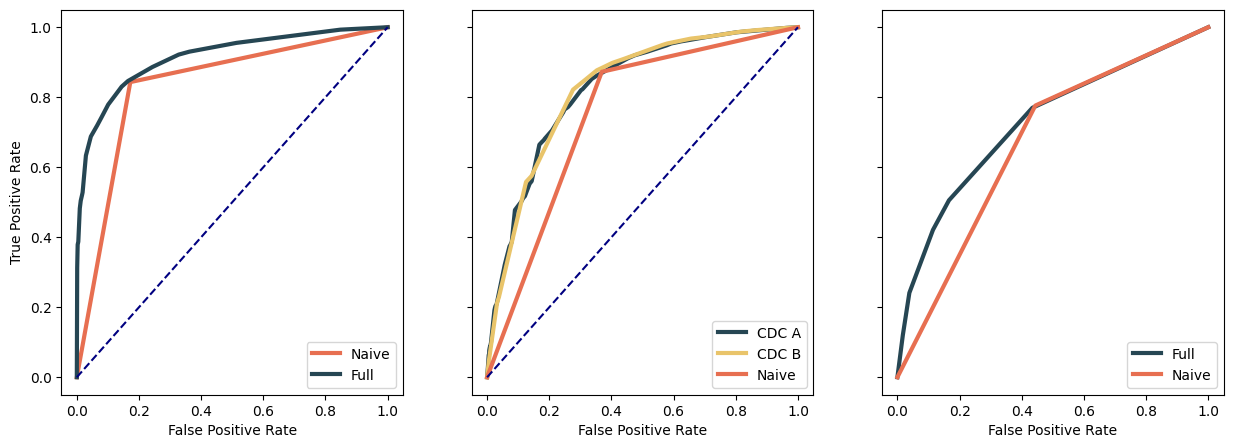

In [85]:
fig, axs = plt.subplots(1,3, figsize=(15, 5), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')


RocCurveDisplay.from_estimator(naive_period_fit, X_test_naive_period, y_test_naive_period, ax = axs[0], linewidth=3, color = naive_colour, label = "Naive")
RocCurveDisplay.from_estimator(Full_period_fit, X_test_full_period, y_test_full_period, color = colour_a, ax = axs[0], linewidth=3, label = "Full")
axs[0].plot([0, 1], [0, 1], color='navy', linestyle='--')

RocCurveDisplay.from_estimator(CDC_exact_fit, X_test_CDC_exact, y_test_CDC_exact, ax = axs[1], linewidth=3, color = colour_a, label = "CDC A")
RocCurveDisplay.from_estimator(CDC_exact_enhanced_fit, X_test_CDC_exact_enhanced, y_test_CDC_exact_enhanced, color = colour_b, ax = axs[1], linewidth=3, label = "CDC B")
RocCurveDisplay.from_estimator(naive_exact_fit, X_test_naive_exact, y_test_naive_exact, color = naive_colour, ax = axs[1], linewidth=3, label = "Naive")

axs[1].plot([0, 1], [0, 1], color='navy', linestyle='--')

RocCurveDisplay.from_estimator(Full_shifted_fit, X_test_full_shifted, y_test_full_shifted, ax = axs[2], linewidth=3, color = colour_a, label = "Full")
RocCurveDisplay.from_estimator(naive_shifted_fit, X_test_naive_shifted, y_test_naive_shifted, color = naive_colour, ax = axs[2], linewidth=3, label = "Naive")

axs[0].set_xlabel('False Positive Rate')
axs[1].set_xlabel('False Positive Rate')
axs[2].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[1].set_ylabel('')
axs[2].set_ylabel('')

plt.legend(loc='lower right')
